# Защита персональных данных клиентов

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Lock-dynamic-gradient.png/480px-Lock-dynamic-gradient.png 'Vijay Verma')

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуем корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных
Познакомимся с имеющимися данными.

In [51]:
! gdown 1DEoD8Pi0UXc4uV380LwYC79Vw5wLByPI

Downloading...
From: https://drive.google.com/uc?id=1DEoD8Pi0UXc4uV380LwYC79Vw5wLByPI
To: /content/insurance.csv
100% 95.7k/95.7k [00:00<00:00, 61.8MB/s]


In [52]:
! pip install phik --quiet

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression

In [54]:
sns.set_theme(style='darkgrid')
sns.set(rc={"figure.figsize":(15, 7)})

In [55]:
try:
  df = pd.read_csv('/content/insurance.csv')
except:
  print('Возникла проблема при загрузке данных')

In [56]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


In [59]:
df.duplicated().sum()

153

In [60]:
df = df.drop_duplicates()

In [61]:
# контроль
df.duplicated().sum()

0

Итак, нам доступен файл с данными 5000 клинетов. Пропусков данных нет. Было обнаружено 153 явных дупликата, которые мы отбросили. Возможно тип данных для столбца `Возраст` определился не очень удачно — скорее всего можно использовать целочисленный тип данных.

## Исследовательский анализ данных

Посмотрим на наши данные повнимательнее.

In [62]:
df['Пол'].value_counts(normalize=True).to_frame()

,Пол
0,0.501547
1,0.498453


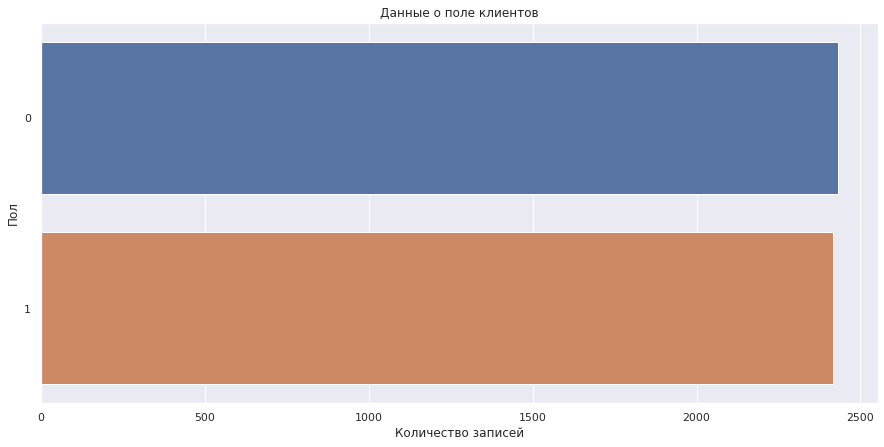

In [63]:
sns.countplot(data=df, y='Пол')\
.set(title='Данные о поле клиентов',
     xlabel='Количество записей');

В наших данных примерно поровну записей о клиентах-женщинах и клиентах-мужчинах, замечательно.

Преобразуем тип данных в колонке «Возраст» в целочисленный и посмотрим на результат.

In [64]:
# убедимся, что все данные подходят для преобразования
(df['Возраст'] % 1).sum()

0.0

In [65]:
df['Возраст'] = df['Возраст'].astype(int)

In [66]:
# контроль
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                4847 non-null   int64  
 1   Возраст            4847 non-null   int64  
 2   Зарплата           4847 non-null   float64
 3   Члены семьи        4847 non-null   int64  
 4   Страховые выплаты  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 356.2 KB


In [67]:
df['Возраст'].describe()

count    4847.000000
mean       31.023932
std         8.487995
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: Возраст, dtype: float64

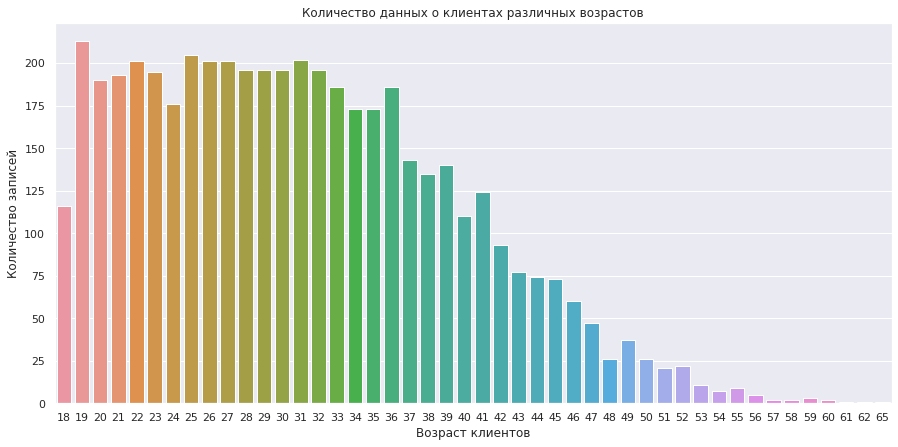

In [68]:
count = sns.countplot(data=df, x='Возраст')
count.set(title='Количество данных о клиентах различных возрастов',
         ylabel='Количество записей',
         xlabel='Возраст клиентов');

В данных содержится информация о клиентах возрастом от 18 до 65 лет, при этом значительной части клиентов от 24 до 37 лет.

In [69]:
df['Зарплата'].describe()

count     4847.000000
mean     39895.811842
std       9972.953985
min       5300.000000
25%      33200.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: Зарплата, dtype: float64

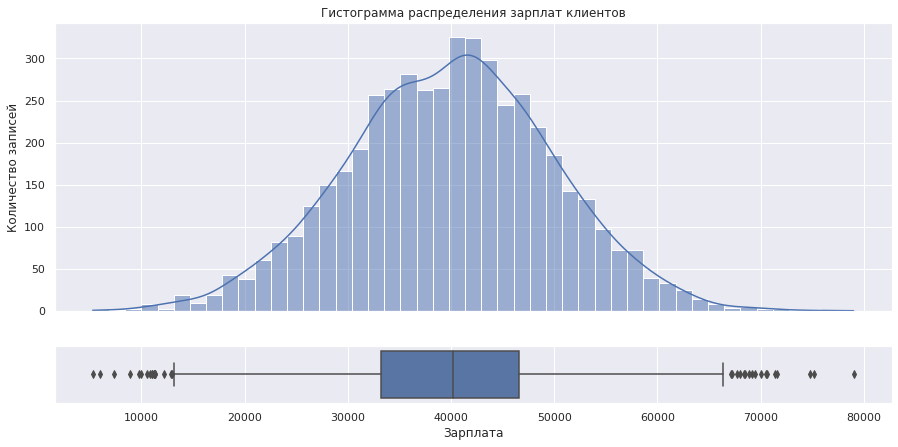

In [70]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df, x='Зарплата', kde=True, ax=axs_hist)
box = sns.boxplot(data=df, x='Зарплата', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения зарплат клиентов',
         ylabel='Количество записей');

Распределение зарплат клиентов похоже на нормальное со средним около 40000 и стандартным отклонением около 10000. Посмотрим на график, показывающий зависимость зарплаты от возраста.

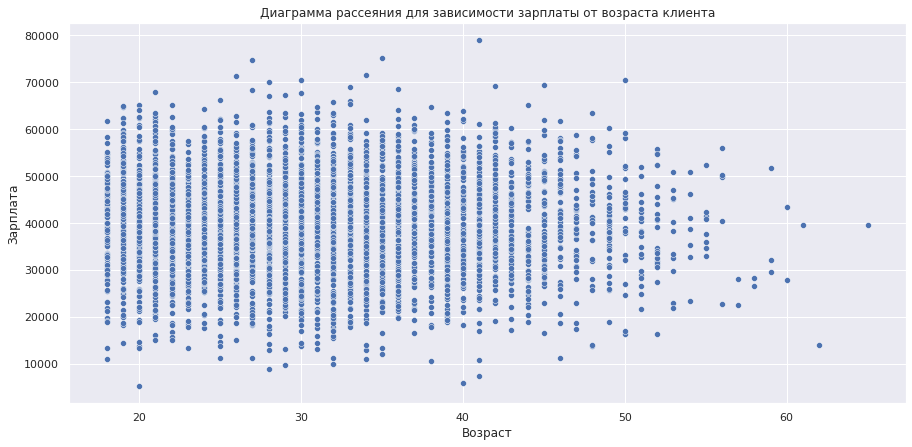

In [71]:
sns.scatterplot(data=df, x='Возраст', y='Зарплата')\
.set(title='Диаграмма рассеяния для зависимости зарплаты от возраста клиента');

Странно. Можно было ожидать, что с возрастом средняя зарплата клиента будет расти. Позднее, когда мы построим матрицу корреляций признаков, следует обратить внимание, будет ли наблюдаться корреляция между зарплатой и возрастом.

In [72]:
df['Члены семьи'].value_counts(normalize=True).to_frame()

,Члены семьи
1,0.360635
0,0.301424
2,0.214153
3,0.090159
4,0.025583
5,0.006602
6,0.001444


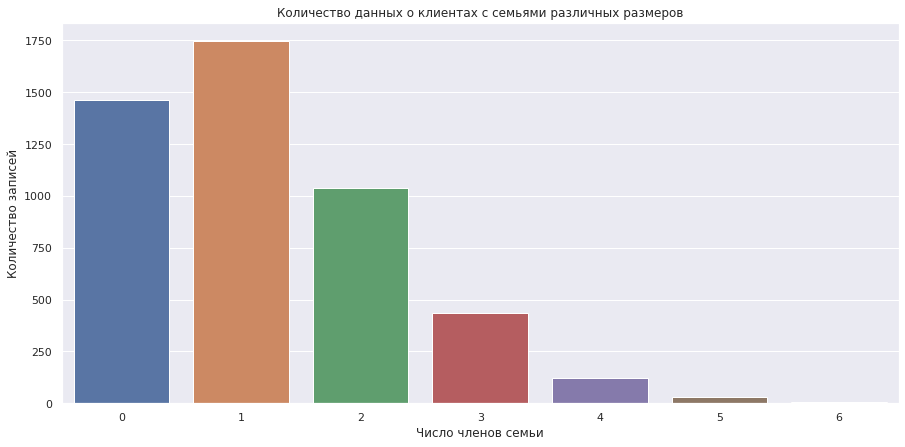

In [73]:
count = sns.countplot(data=df, x='Члены семьи')
count.set(title='Количество данных о клиентах с семьями различных размеров',
         ylabel='Количество записей',
         xlabel='Число членов семьи');

Видно, что в наших данных большинство клиентов имеют от нуля до двух челнов семьи. Число записей о клиентах, имеющих пять или шесть членов семьи, довольно мало.

In [74]:
df['Страховые выплаты'].value_counts(normalize=True).to_frame()

,Страховые выплаты
0,0.883846
1,0.087270
2,0.023520
3,0.003714
4,0.001444
5,0.000206


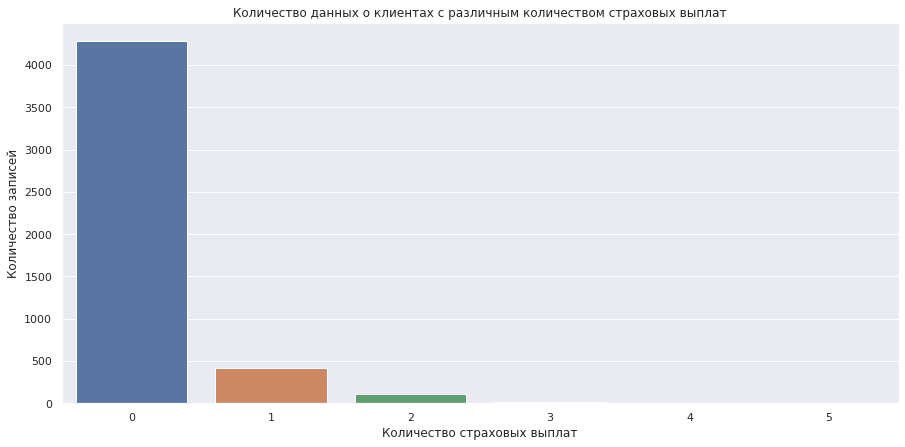

In [75]:
count = sns.countplot(data=df, x='Страховые выплаты')
count.set(title='Количество данных о клиентах с различным количеством страховых выплат',
         ylabel='Количество записей',
         xlabel='Количество страховых выплат');

Видно, что большинство клиентов не получают страховых выплат. Целевой признак не сбалансирован, что необходимо будет учесть при построении моделей.

Построим матрицу корреляций.

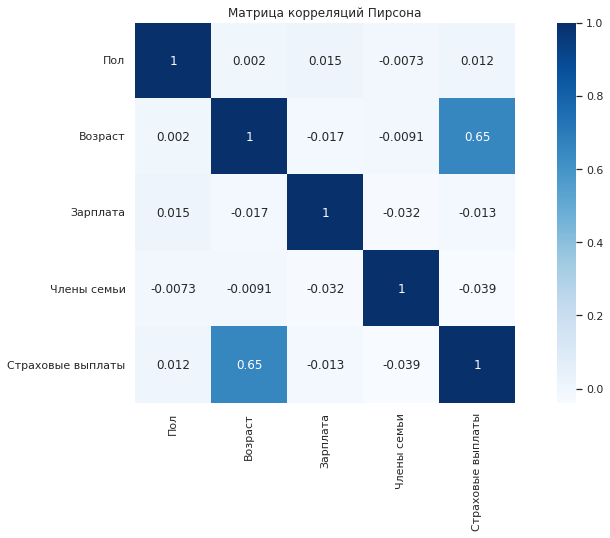

In [76]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='Blues', square=True)\
.set(title='Матрица корреляций Пирсона');

interval columns not set, guessing: ['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']


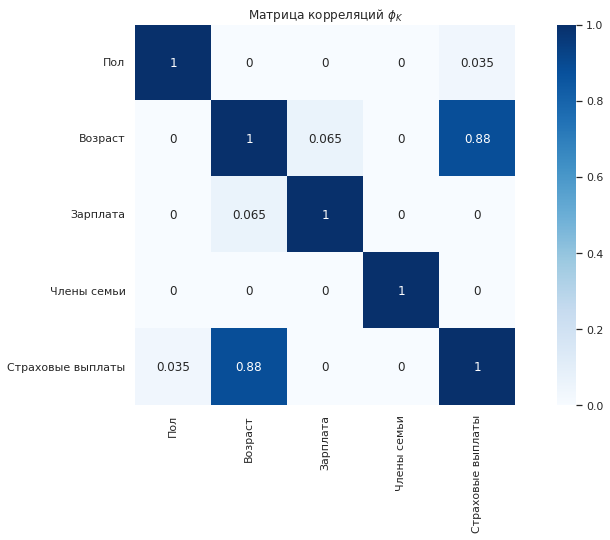

In [77]:
phik = df.phik_matrix()
sns.heatmap(phik, annot=True, cmap='Blues', square=True)\
.set(title='Матрица корреляций $\phi_K$');

Оба теста показали значительную корреляцию между возрастом и страховыми выплатами, что выглядит правдоподобно. При этом ранее мы обратили внимание на отсутствие выраженной зависимости между возрастом и зарплатой клиента, эта гипотеза подтвердилась на обоих тестах. Возможно имеющиеся у нас данные — синтетические.

### Промежуточный вывод

Был проведён небольшой исследовательский анализ данных. После устранения незначительной проблемы с определением типа данных в столбце `Возраст` было установлено следующее:
* в данных содержатся записи о клиентах-женщинах и клиентах-мужчинах, причём их примерно поровну
* в данных содержится информация о клиентах возрастом от 18 до 65 лет, при этом значительной части клиентов от 24 до 37 лет
* распределение зарплат клиентов похоже на нормальное со средним около 40000 и стандартным отклонением около 10000. При этом корреляции зарплаты и возраста клиента не наблюдается, что даёт основания предполагать, что данные — синтетические
* у большинства клиентов до 2 членов семьи
* большинство клиентов не получают страховых выплат — целевой признак не сбалансирован, что необходимо будет учесть при построении моделей
* наблюдается значительная корреляция между возрастом клиента и количеством страховых выплат.

## Умножение матриц

В соответствии с поставленной задачей нам нужно ответить на вопрос: изменится ли качество линейной регрессии, если признаки умножить на обратимую матрицу.

Введём несколько обозначений:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** 

При умножении признаков $X$ на обратимую матрицу $P$ качество линейной регрессии не изменится.



**Обоснование:** 

Пусть $a_1$ — предсказания линейной регресии для матрицы признаков $X$. Тогда обозначим предсказания для матрицы признаков $X$ после умножения на обратимую матрицу $P$ как $a_2$. Нам нужно показать, что $a_1 = a_2$.

Распишем формулы для $a_1$ и $a_2$. Обозначим вектор весов линейной регрессии с матрицей признаков $X$ как $w_1$, а с матрицей признаков $X \cdot P$ — как $w_2$.

$$ a_1 = X \cdot w_1$$

$$ a_2 = X \cdot P \cdot w_2 $$

Вектора весов $w_1$ и $w_2$ определяются по формулам:

$$ w_1 = (X^T \cdot X)^{-1} \cdot X^T \cdot y $$
$$ w_2 = \left((X \cdot P)^T \cdot X \cdot P \right)^{-1} (X \cdot P)^T \cdot y $$

Подставим их в формулы для $a_1$ и $a_2$, чтобы показать, что $a_1 = a_2$.

$$ X \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y = X \cdot P \cdot \left((X \cdot P)^T \cdot X \cdot P \right)^{-1} (X \cdot P)^T \cdot y $$

Вспомним свойства [обратных матриц](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0) — для двух невырожденных квадратных матриц $A$ и $B$ верно следующее:

$$(A \cdot B)^{-1} = B^{-1} \cdot A^{-1}$$

$$\left(A^T\right)^{-1} = \left(A^{-1}\right)^T$$

$$ (A \cdot B)^T = B^T \cdot A^T $$

С учётом этих свойств представим наше уравнение в следующем виде:

$$ X \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y =
X \cdot P \cdot \left(P^T \cdot X^T \cdot X \cdot P \right)^{-1} (X \cdot P)^T \cdot y $$

$$ X \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y =
X \cdot P \cdot P^{-1} \cdot \left(X^T \cdot X \right)^{-1} \cdot \left( P^T\right)^{-1} \cdot P^T \cdot X^T \cdot y $$

Из определения обратной матрицы следует:

$$ A \cdot A^{-1} = A^{-1} \cdot A = E,$$

где $E$ — [единичная матрица](https://ru.wikipedia.org/wiki/%D0%95%D0%B4%D0%B8%D0%BD%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0). Вспомним, что произведение любой матрицы и единичной матрицы подходящего размера равно самой матрице:

$$ A \cdot E=E \cdot A=A $$

Тогда наше равенство сокращается до:

$$ X \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y = X \cdot E \cdot (X^T \cdot X)^{-1} \cdot E \cdot X^T \cdot y $$

$$ X \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y = X \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y $$

quod erat demonstrandum.

### Промежуточный вывод

Мы показали, что при умножении матрицы признаков $X$ на обратимую матрицу $P$ качество линейной регрессии не изменяется. Для этого мы продемонстрировали, что после умножнеия $X$ на $P$ вектор предсказаний модели не изменяется. Данное свойство пригодится нам на следующем этапе исследования.

## Алгоритм преобразования

Предложим алгоритм предобразования данных, который мог бы защитить персональные данные клиентов. Ранее мы показали, что при умножении матрицы признаков на обратимую матрицу качество линейной модели не изменяется. Исходя из этого предлагается следующий алгоритм.

**Алгоритм**

1.   Разделим данные на обучающие признаки (`Пол`, `Возраст`, `Зарплата`, `Члены семьи`) и целевой признак (`Страховые выплаты`)
2.   Создадим случайную матрицу размером $4 \times 4$ (у нас четыре обучающих признака)
3. Проверим случайную матрицу на обратимость. Если матрица необратима — вернёмся к шагу 2, в противном случае — перейдём к следующему шагу
4. Произведём умножение матрицы обучающих признаков на случайную обратимую матрицу



**Обоснование**

Ранее нами было показано, что при умножении матрицы признаков на обатимую матрицу качество линейной регрессии не изменяется. При этом значения обучающих признаков изменяются непредсказуемым образом, так что злоумышленнику будет проблематично восстановить исходные значения.

## Проверка алгоритма

Проверим наш алгоритм. Для этого разделим нашу выборку на обучающие и целевой признаки, обучим линейную регрессию на обучающих признаках, а потом — на обучающих признаках, умноженных на обратимую матрицу. Если метрика при этом не изменится — значит у нас нет оснований отклонить гипотезу о том, что умножение матриц не приводит к изменению качества регресии!

Для начала посмотрим на линейную регрессию, обученную на матрице $X$.

In [78]:
X = df[['Пол', 'Возраст', 'Зарплата', 'Члены семьи']]
y = df['Страховые выплаты']

In [79]:
lr_X = LinearRegression()
lr_X.fit(X, y)

LinearRegression()

In [80]:
X_score = lr_X.score(X, y)

In [81]:
print('R2_X:', X_score)

R2_X: 0.4302010044852067


Отлично. Теперь создадим обратимую матрицу размера $4 \times 4$ и посмотрим, что получится.

In [82]:
state = np.random.RandomState(42)

In [83]:
inverse = False

while not inverse:
  P = state.rand(4, 4)
  try:
    P_inv = np.linalg.inv(P)
    inverse = True
  except np.linalg.LinAlgError:
    print('Matrix P was not invertible, retrying...')

Посмотрим на нашу новую прекрасную матрицу:

In [84]:
pd.DataFrame(P)

,0,1,2,3
0,0.374540,0.950714,0.731994,0.598658
1,0.156019,0.155995,0.058084,0.866176
2,0.601115,0.708073,0.020584,0.969910
3,0.832443,0.212339,0.181825,0.183405


А как будет выглядеть матрица обучающих признаков после умножения?

In [85]:
XP = X @ P
XP.columns = X.columns
XP.head()

,Пол,Возраст,Зарплата,Члены семьи
0,29822.908329,35127.958687,1024.286164,48143.823952
1,22850.379746,26914.146043,785.064454,36896.601889
2,12627.939787,14874.047975,433.958805,20393.226004
3,25071.437266,29530.327057,859.956818,40463.797343
4,15693.844869,18486.012841,539.613636,25339.498732


Да уж, защитили так защитили...
Ну чтож, приступим!

In [86]:
lr_XP = LinearRegression()
lr_XP.fit(X @ P, y)

LinearRegression()

In [87]:
XP_score = lr_XP.score(X @ P, y)

In [88]:
print('R2_XP:', XP_score)

R2_XP: 0.4302010044851896


In [89]:
if round(XP_score, 3) == round(X_score, 3):
  print('Нет оснований отклонять гипотезу')
else:
  print('Ох, что-то грустно всё, гипотезу можно отклонить')

Нет оснований отклонять гипотезу


### Промежуточный вывод
Для проверки предложенного ранее алгоритма мы создали две модели линейной регрессии. Первую модель обучили на обучающих признаках без изменений, вторую — на обучающих признаках, умноженных на случайную обратимую матрицу. Мы показали, что метрика $R_2$ у обоих регрессий не отличается, а значит у нас нет оснований полагать, что предложенный алгоритм защиты данных не работает.

## Общий вывод по проекту

В рамках данного проекта нам нужно было защитить данные клиентов страховой компании «Хоть потоп». Для этого требовалось разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.

При этом нужно было защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требовалось.

Нам доступен файл с данными 5000 клинетов. Пропусков данных в файле нет. Было обнаружено 153 явных дупликата, которые мы отбросили. Было установлено, что в колонке `Возраст` тип данных можно изменить на целочисленный.

Был проведён небольшой исследовательский анализ данных. После устранения незначительной проблемы с определением типа данных в столбце `Возраст` было установлено следующее:
* в данных содержатся записи о клиентах-женщинах и клиентах-мужчинах, причём их примерно поровну
* в данных содержится информация о клиентах возрастом от 18 до 65 лет, при этом значительной части клиентов от 24 до 37 лет
* распределение зарплат клиентов похоже на нормальное со средним около 40000 и стандартным отклонением около 10000. При этом корреляции зарплаты и возраста клиента не наблюдается, что даёт основания предполагать, что данные — синтетические
* у большинства клиентов до 2 членов семьи
* большинство клиентов не получают страховых выплат — целевой признак не сбалансирован, что необходимо будет учесть при построении моделей
* наблюдается значительная корреляция между возрастом клиента и количеством страховых выплат.

В рамках выполнения проекта мы математически показали, что при умножении матрицы признаков $X$ на обратимую матрицу $P$ качество линейной регрессии не изменяется. Для этого мы продемонстрировали, что после умножнеия $X$ на $P$ вектор предсказаний модели не изменяется. 

На основании этого мы предложили следующий алгоритм защиты данных:
1.   Данные разделяются на обучающие признаки и целевой признак
2.   Создаётся случайная обратимая матрица
3.   Матрица обучающих признаков умножается на новую матрицу

Для проверки предложенного алгоритма мы создали две модели линейной регрессии. Первую модель обучили на обучающих признаках без изменений, вторую — на обучающих признаках, умноженных на случайную обратимую матрицу. Мы показали, что метрика $R_2$ у обоих регрессий не отличается, а значит у нас нет оснований полагать, что предложенный алгоритм защиты данных не работает.